In [1]:
import cv2
import time
import yaml
import os
import io
import hashlib
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from object_detection.utils import ops as utils_ops
from lxml import etree
from utils import label_map_util
from utils import visualization_utils as vis_util


%matplotlib inline

E:\projects\python\models\research\object_detection\utils\visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\Alexa\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Alexa\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Alexa\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Alexa\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().sta

In [2]:
LABEL_DICT = {
    'Green': 1,
    'GreenLeft': 2,
    'GreenRight': 3,
    'GreenStraight': 4,
    'GreenStraightLeft': 5,
    'GreenStraightRight': 6,
    'Red': 7,
    'RedLeft': 8,
    'RedRight': 9,
    'RedStraight': 10,
    'RedStraightLeft': 11,
    'Yellow': 12,
    'off': 13
}

def load_image(path):
    return mpimg.imread(path)

def png_to_jpeg(png_file, jpeg_file):
    im = PIL.Image.open(png_file)
    rgb_im = im.convert('RGB')
    rgb_im.save(jpeg_file, 'JPEG')

def show_label_images(input_yaml, output_folder=None):
    """
    Shows and draws pictures with labeled traffic lights.
    Can save pictures.
    :param input_yaml: Path to yaml file
    :param output_folder: If None, do not save picture. Else enter path to folder
    """
    images = get_all_labels(input_yaml)
    
    if output_folder is not None:
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

    for i, image_dict in enumerate(images):
        ## read in with matplotlib instead of cv2.imread() 
        ## because cv2.imread() imports images in BGR color space
#         image = load_image(image_dict['path'])
        image = cv2.imread(image_dict['path'])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image is None:
            raise IOError('Could not open image path', image_dict['path'])

        for box in image_dict['boxes']:
            ## switch because it's BGR
            if 'red' in box['label'].lower():
                color = (0, 0, 255)
            elif 'green' in box['label'].lower():
                color = (0, 255, 0)
            else:
                color = (0, 255, 255)
                    
            cv2.rectangle(image,
                          (int(round(box['x_min'])), int(round(box['y_min']))),
                          (int(round(box['x_max'])), int(round(box['y_max']))),
                          color)

#         cv2.imshow('labeled_image', image)
#         cv2.waitKey(10)
        if output_folder is not None:
            cv2.imwrite(os.path.join(output_folder, str(i).zfill(10) + '_'
                        + os.path.basename(image_dict['path'])), image)
    

def get_all_labels(input_yaml, riib=False):
    """ Gets all labels within label file
    Note that RGB images are 1280x720 and RIIB images are 1280x736.
    :param input_yaml: Path to yaml file
    :param riib: If True, change path to labeled pictures
    :return: images: Labels for traffic lights
    """
    images = yaml.load(open(input_yaml, 'rb').read())
    
    width, height, img_format = None, None, None
    for image in images:
        image['path'] = os.path.abspath(os.path.join(os.path.dirname(input_yaml), image['path']))
        if width is None and height is None and img_format is None:
            ## assume all images have the same properties
            img = load_image(image['path'])
            height = img.shape[0]
            width = img.shape[1]
            img_format = image['path'].split('.')[-1]
            
        image.update({'height': height, 'width': width, 'img_format': img_format})
        if riib:
            image['path'] = image['path'].replace('.png', '.pgm')
            image['path'] = image['path'].replace('rgb/train', 'riib/train')
            image['path'] = image['path'].replace('rgb/test', 'riib/test')
            for box in image['boxes']:
                box['y_max'] = box['y_max'] + 8
                box['y_min'] = box['y_min'] + 8
        
        # create jpeg subdirectory
        jpeg_dir = os.path.join(os.path.dirname(image['path']), 'jpeg')
        if not os.path.exists(jpeg_dir):
            os.makedirs(jpeg_dir)

        if image['path'].split('.')[-1].lower() == 'png':
            png_file = image['path']
            image['path'] = image['path'].replace(os.path.dirname(image['path']), jpeg_dir)
            image['path'] = image['path'].replace('.png', '.jpg')
            # convert images to jpeg if they don't already exist
            if not os.path.isfile(image['path']):
                png_to_jpeg(png_file, image['path'])
                
    return images

def create_label_dict(examples):
    labels = []
    for example in examples:
        for box in example['boxes']:
            labels.append(box['label'])
    label_dict = {}
    for i, label in enumerate(list(set(labels)), 1):
        label_dict.update({label: i})
    
    return label_dict

def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

def create_tf_example(example):
    """
    Creates a tf.Example proto from sample cat image.
    :param example: dict with height, width, image path, image format and boxes
    :param label_dict: dict of of labels with id e.g. {'Green': 1}
    """
    height = example['height'] # Image height
    width = example['width'] # Image width
    filename = example['path'].encode() # Filename of the image. Empty if image is not from file
    
    with tf.gfile.GFile(example['path'], 'rb') as fid:
        encoded_image_data = fid.read() # Encoded image bytes
        
    image_format = example['img_format'].encode() # b'jpeg' or b'png'

    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)
    
    for box in example['boxes']:
        xmins.append(box['x_min'] / width)
        xmaxs.append(box['x_max'] / width)
        ymins.append(box['y_min'] / height)
        ymaxs.append(box['y_max'] / height)
        classes_text.append(box['label'].encode())
        classes.append(LABEL_DICT[box['label']])

    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_image_data),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

def dict_to_tf_example(data,
                       dataset_directory,
                       label_map_dict,
                       ignore_difficult_instances=False):
    """Convert XML derived dict to tf.Example proto.

    Notice that this function normalizes the bounding box coordinates provided
    by the raw data.

    Args:
    data: dict holding PASCAL XML fields for a single image (obtained by
      running dataset_util.recursive_parse_xml_to_dict)
    dataset_directory: Path to root directory holding PASCAL dataset
    label_map_dict: A map from string label names to integers ids.
    ignore_difficult_instances: Whether to skip difficult instances in the
      dataset  (default: False).
    image_subdirectory: String specifying subdirectory within the
      PASCAL dataset directory holding the actual image data.

    Returns:
    example: The converted tf.Example.

    Raises:
    ValueError: if the image pointed to by data['filename'] is not a valid JPEG
    """
#     img_path = os.path.join(data['folder'], data['filename'])
#     full_path = os.path.abspath(img_path)
    with tf.gfile.GFile(data['path'], 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = PIL.Image.open(encoded_jpg_io)
    if image.format != 'JPEG':
        raise ValueError('Image format not JPEG')
    key = hashlib.sha256(encoded_jpg).hexdigest()

    width = int(data['size']['width'])
    height = int(data['size']['height'])

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
    truncated = []
    poses = []
    difficult_obj = []
    for obj in data['object']:
        difficult = bool(int(obj['difficult']))
        if ignore_difficult_instances and difficult:
            continue

        difficult_obj.append(int(difficult))

        xmin.append(float(obj['bndbox']['xmin']) / width)
        ymin.append(float(obj['bndbox']['ymin']) / height)
        xmax.append(float(obj['bndbox']['xmax']) / width)
        ymax.append(float(obj['bndbox']['ymax']) / height)
        classes_text.append(obj['name'].encode('utf8'))
        classes.append(label_map_dict[obj['name']])
        truncated.append(int(obj['truncated']))
        poses.append(obj['pose'].encode('utf8'))

    example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(data['filename'].encode('utf8')),
      'image/source_id': dataset_util.bytes_feature(data['filename'].encode('utf8')),
      'image/key/sha256': dataset_util.bytes_feature(key.encode('utf8')),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature('jpeg'.encode('utf8')),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmin),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmax),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymin),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymax),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
      'image/object/difficult': dataset_util.int64_list_feature(difficult_obj),
      'image/object/truncated': dataset_util.int64_list_feature(truncated),
      'image/object/view': dataset_util.bytes_list_feature(poses),
    }))
    return example

def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [3]:
# BOSCH_YAML = 'data/dataset_train_rgb/train.yaml'
# BOSCH_YAML = 'data/dataset_test_rgb/test.yaml'

# BOSCH_YAML = 'data/dataset_train_rgb/train.yaml'
# examples = get_all_labels(BOSCH_YAML)


# label_dict = create_label_dict(examples)
#show_label_images('data/dataset_train_rgb/train.yaml') #, output_folder='data/bosch_train_label')

In [4]:
# # output_path = 'data/bosch_validation.record'
# # # output_path = 'data/udacity_test.record'

# writer = tf.python_io.TFRecordWriter('bosch-jpeg-test.record')
# # # label_map_dict = label_map_util.get_label_map_dict('data/label_map.pbtxt')

# for i, example in enumerate(examples):
#     print(example['path'])
#     tf_example = create_tf_example(example)
#     writer.write(tf_example.SerializeToString())

# writer.close()

In [5]:
# E:\projects\python\Traffic-Light-Classification\data\dataset_train_rgb\rgb\train\2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag\jpeg\207374.jpg
# E:\projects\python\Traffic-Light-Classification\data\dataset_train_rgb\rgb\train\2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag\jpeg\207384.jpg
# E:\projects\python\Traffic-Light-Classification\data\dataset_train_rgb\rgb\train\2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag\jpeg\207386.jpg
# E:\projects\python\Traffic-Light-Classification\data\dataset_train_rgb\rgb\train\2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag\jpeg\207390.jpg
# E:\projects\python\Traffic-Light-Classification\data\dataset_train_rgb\rgb\train\2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag\jpeg\207458.jpg

In [6]:
# output_path = 'data/udacity_test.record'

# writer = tf.python_io.TFRecordWriter(output_path)

# data_dir = 'data/udacity_testarea_rgb'
# label_map_dict = label_map_util.get_label_map_dict('data/label_map.pbtxt')

# annotations_dir = os.path.join(data_dir, 'labels')
# # examples_list = dataset_util.read_examples_list(os.path.abspath(data_dir))
# examples_list = [name.split('.')[0] for name in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, name))]

# for idx, example in enumerate(examples_list):
#     path = os.path.join(annotations_dir, example + '.xml')
#     with tf.gfile.GFile(path, 'r') as fid:
#         xml_str = fid.read()
#     xml = etree.fromstring(xml_str)
#     data = dataset_util.recursive_parse_xml_to_dict(xml)['annotation']

#     tf_example = dict_to_tf_example(data, data_dir, label_map_dict)
#     writer.write(tf_example.SerializeToString())

# writer.close()

In [7]:
## Test model
PATH_TO_CKPT = 'fine_tuned_model/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'label_map.pbtxt')
NUM_CLASSES = 13

In [8]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [9]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [10]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = './'
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 7) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [11]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                        tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
            # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

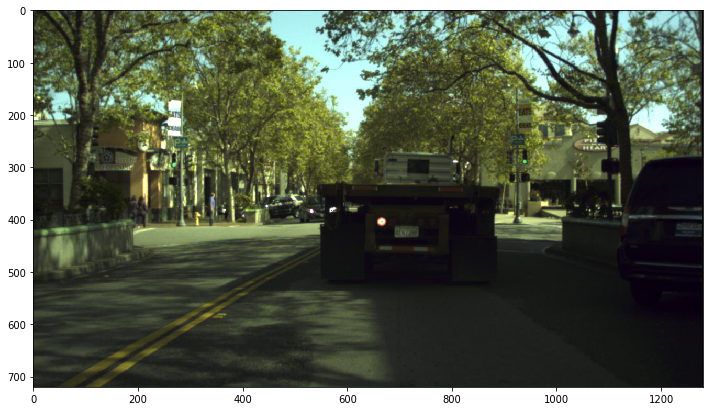

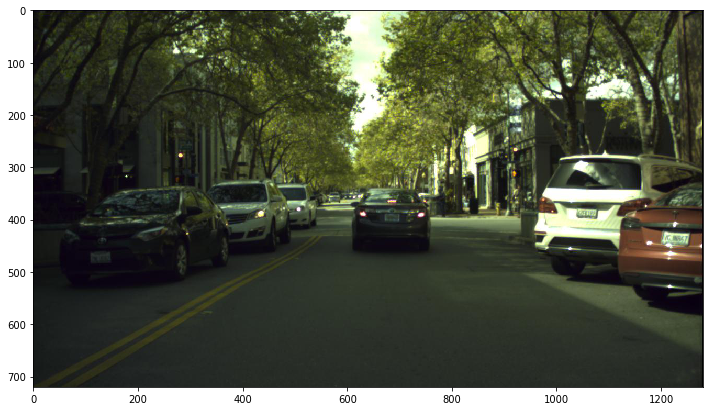

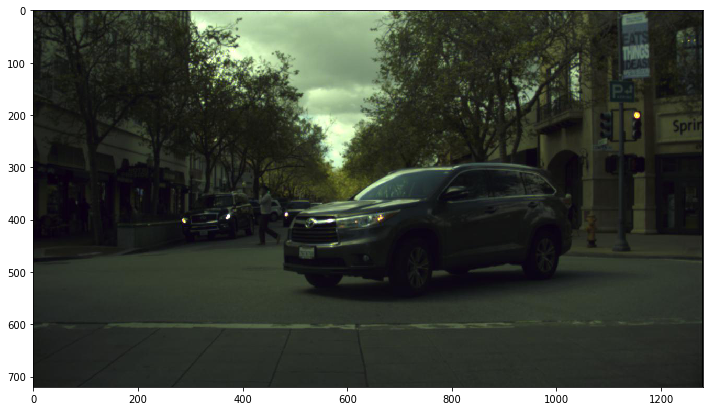

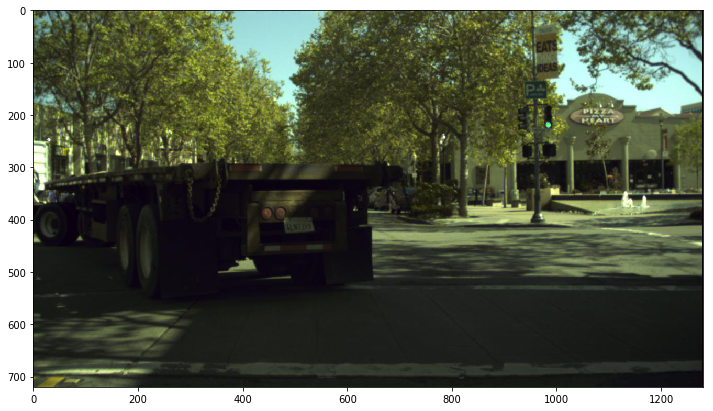

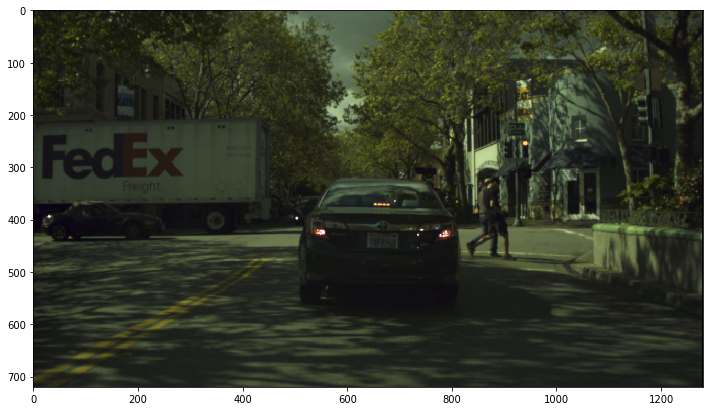

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [12]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)